In [1]:
# Handle imports required for project
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import fastf1 as ff1
from fastf1 import plotting

In [2]:
# Setup the base information for the year
year = 2024
qualis = []
races = []
season = ff1.get_event_schedule(year=year, include_testing=False)
print("2024 Season Rounds", season['EventName'])
# create session IDs to load data
for round in season['RoundNumber']:
    qualis.append(ff1.get_session(year=year, gp=round,identifier = 'Q'))
    races.append(ff1.get_session(year=year, gp=round,identifier = 'R'))

req         WARNING 	DEFAULT CACHE ENABLED! (3.77 GB) /Users/seancoffey/Library/Caches/fastf1


2024 Season Rounds 1            Bahrain Grand Prix
2      Saudi Arabian Grand Prix
3         Australian Grand Prix
4           Japanese Grand Prix
5            Chinese Grand Prix
6              Miami Grand Prix
7     Emilia Romagna Grand Prix
8             Monaco Grand Prix
9           Canadian Grand Prix
10           Spanish Grand Prix
11          Austrian Grand Prix
12           British Grand Prix
13         Hungarian Grand Prix
14           Belgian Grand Prix
15             Dutch Grand Prix
16           Italian Grand Prix
17        Azerbaijan Grand Prix
18         Singapore Grand Prix
19     United States Grand Prix
20       Mexico City Grand Prix
21         São Paulo Grand Prix
22         Las Vegas Grand Prix
23             Qatar Grand Prix
24         Abu Dhabi Grand Prix
Name: EventName, dtype: object


In [3]:
# function to label telemetry with corner name
def get_corner(distance):
    corner_filter = (circuit_corners['corner_start'] < distance) & (circuit_corners['corner_end'] > distance)
    candidate_corners = circuit_corners.loc[corner_filter,['corner']]
    try:
        corner = candidate_corners.iloc[-1,-1]
    except:
        corner = 'straight'  # if there is no corner, we must be on a straight
    return corner

def get_corner_type(corner):
    if corner == 'straight':
        return 'straight'
    else:
        return circuit_corners[circuit_corners['corner'] == corner]['type'].values[0]

# function to populate corners data
def prepare_corner_info(lap,corners,event):
    # prepare corners dataframe from circuit info
    corners['corner_start'] = corners['Distance'] - 75
    corners['corner_end'] = corners['Distance'] + 75
    corners['corner'] = corners['Number'].apply(str) + corners['Letter'].apply(str)

    # add corner names to telemetry
    telemetry = lap.telemetry.add_distance()
    telemetry['corner'] = telemetry['Distance'].apply(get_corner)
    # add corner speeds to corner information - based on fastest lap
    corner_speeds = telemetry.groupby('corner')['Speed'].aggregate(['mean','min'])
    corners = corners.join(corner_speeds, on='corner')
    corners = corners.rename(columns={'mean':'avg_corner_speed','min':'min_corner_speed','Distance':'distance','Number':'number'})
    # categorize corners based on min speed thru corner
    speed_bins = [0,120,220,400]
    corner_types = ['slow','medium','fast']
    corners['type'] = pd.cut(x=corners['min_corner_speed'], bins=speed_bins, labels=corner_types, include_lowest=True)
    # prepare corners information to save to file
    corners['event'] = event
    corners = corners[['event','number','corner','type','distance','corner_start','corner_end','avg_corner_speed','min_corner_speed']]
    return corners

In [5]:
# loop through events to create corner and qualifying data

# initialise dataframes to hold output
corners = pd.DataFrame(columns = ['event', 'number', 'corner', 'type', 'distance', 'corner_start',
                                  'corner_end', 'avg_corner_speed', 'min_corner_speed'])

quali_performance = pd.DataFrame(columns = ['event', 'driver', 'driver_number', 'team', 'best_lap_time', 's1_time',
       's2_time', 's3_time', 'speed_trap', 'slow_min', 'slow_avg',
       'medium_min', 'medium_avg', 'fast_min', 'fast_avg', 'total_brake_time',
       'best_lap_time_norm', 's1_time_norm', 's2_time_norm', 's3_time_norm',
       'speed_trap_norm', 'slow_min_norm', 'slow_avg_norm', 'medium_min_norm',
       'medium_avg_norm', 'fast_min_norm', 'fast_avg_norm',
       'total_brake_time_norm'])

missing_laps = pd.DataFrame(columns = ['event','driver'])
# Loop through all races in a season
for quali in qualis:
    quali.load()
    lap = quali.laps.pick_fastest()
    driver = lap.Driver # using pole sitter info to determine corner characteristics
    pos = lap.get_pos_data()
    circuit_info = quali.get_circuit_info()
    weekend = quali.event
    circuit_corners = circuit_info.corners
    # populate corner data for this circuit
    circuit_corners = prepare_corner_info(lap,circuit_corners,weekend.EventName)
    # add to overall corner information for 2024
    corners = pd.concat([corners, circuit_corners], ignore_index=True)

    # initialise dataframe for quali results per race
    quali_laps = pd.DataFrame(columns=quali_performance.columns)
    # loop through all drivers that participated
    for driver in quali.drivers:
        lap = quali.laps.pick_drivers(driver).pick_fastest()
        try:
            telemetry = lap.telemetry.add_distance()
            # add a time column for each row to allow calculating total time braking etc
            telemetry['segment_time'] = (telemetry['SessionTime']-telemetry['SessionTime'].shift(1)).dt.total_seconds()
            #telemetry['segment_time'].fillna(0,inplace=True)
            telemetry['corner'] = telemetry['Distance'].apply(get_corner)
            telemetry['corner_type'] = telemetry['corner'].apply(get_corner_type)
            # add corner speeds to corner information - based on fastest lap
            corner_speeds = telemetry.groupby('corner_type')['Speed'].aggregate(['mean','min']).reset_index()

            driver_fastest = pd.DataFrame([{'event':weekend.EventName,
                                            'driver':lap.Driver,
                                            'driver_number':lap.DriverNumber,
                                            'team':lap.Team,
                                            'best_lap_time':lap.LapTime,
                                            's1_time':lap.Sector1Time,
                                            's2_time':lap.Sector2Time,
                                            's3_time':lap.Sector3Time,
                                            'speed_trap':lap.SpeedST,
                                            'slow_min':corner_speeds[corner_speeds['corner_type'] == 'slow']['min'].values[0],
                                            'slow_avg':corner_speeds[corner_speeds['corner_type'] == 'slow']['mean'].values[0],
                                            'medium_min':corner_speeds[corner_speeds['corner_type'] == 'medium']['min'].values[0],
                                            'medium_avg':corner_speeds[corner_speeds['corner_type'] == 'medium']['mean'].values[0],
                                            'fast_min':corner_speeds[corner_speeds['corner_type'] == 'fast']['min'].values[0],
                                            'fast_avg':corner_speeds[corner_speeds['corner_type'] == 'fast']['mean'].values[0],
                                            'total_brake_time': telemetry[telemetry['Brake']==True]['segment_time'].sum(skipna=True)
                                            }])

            quali_laps = pd.concat([quali_laps,driver_fastest], ignore_index=True)
        # if there is no lap data for a driver, record that we have a missing lap
        except:
            missing = pd.DataFrame([{'event':weekend.EventName,
                                            'driver':driver}])
            missing_laps = pd.concat([missing_laps,missing], ignore_index=True)

    #convert time deltas to seconds and normalise all numeric columns
    numeric_cols = quali_laps.select_dtypes(include=[np.number]).columns.tolist()
    time_deltas = quali_laps.select_dtypes(include=['timedelta64']).columns.tolist()
    for time_delta in time_deltas:
        quali_laps[time_delta] = quali_laps[time_delta].dt.total_seconds()
    for col in numeric_cols:
        new_col = col + '_norm'
        quali_laps[new_col] = (quali_laps[col] - quali_laps[col].mean())/quali_laps[col].std()

    quali_performance = pd.concat([quali_performance, quali_laps], ignore_index=True)

# write to file
corners.to_pickle('data/corners.pkl')
quali_performance.to_pickle('data/quali_performance.pkl')

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '11', '14', '4', '81', '44', '27', '22', '18', '23', '3', '20', '77', '24', '2', '31', '10']
/var/folders/kz/34dp2r_x2zlgffjysxmy1_1r0000gn/T/ipykernel_1960/2014839703.py:28: FutureWarning: The behavior

In [4]:
quali_performance = pd.read_pickle('data/quali_performance.pkl')
quali_performance.groupby(['driver'])['event'].count()

driver
ALB    23
ALO    24
BEA     3
BOT    24
COL     9
DOO     1
GAS    24
HAM    24
HUL    24
LAW     6
LEC    24
MAG    22
NOR    24
OCO    23
PER    24
PIA    24
RIC    18
RUS    24
SAI    23
SAR    12
STR    23
TSU    24
VER    24
ZHO    23
Name: event, dtype: int64

In [7]:
missing_laps

,event,driver
0,Saudi Arabian Grand Prix,24
1,Emilia Romagna Grand Prix,2
2,Monaco Grand Prix,23
3,Spanish Grand Prix,18
4,Dutch Grand Prix,2


In [5]:
# Adding circuit information
corners = pd.read_pickle('data/corners.pkl')
circuits = corners.groupby(['event', 'type'], observed=True)['corner'].count().reset_index()
circuits = circuits.pivot(index='event', columns='type', values='corner').reset_index()
circuits

type,event,slow,medium,fast
0,Abu Dhabi Grand Prix,5,5,6
1,Australian Grand Prix,2,5,7
2,Austrian Grand Prix,2,4,4
3,Azerbaijan Grand Prix,7,7,6
4,Bahrain Grand Prix,4,7,4
5,Belgian Grand Prix,4,7,8
6,British Grand Prix,4,4,10
7,Canadian Grand Prix,4,7,3
8,Chinese Grand Prix,9,5,2
9,Dutch Grand Prix,4,4,6


In [6]:
# Adding race performance data
def calc_lap_time_consistency(laps):
    # using the Inter-Quartile Range (IQR) proximity rule
    q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)
    intr_qr = q75 - q25
    laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
    laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR
    laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
    laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

    stint_data = laps.groupby(['DriverNumber','Stint'])['LapTimeSeconds'].aggregate(['count','mean','var']).reset_index()
    stint_data['weighted_mean'] = stint_data['count'] * stint_data['mean']
    stint_data['weighted_var'] = stint_data['count'] * stint_data['var']
    stint_data = stint_data.groupby(['DriverNumber'])[['count','weighted_mean','weighted_var']].sum().reset_index()
    stint_data['avg_race_pace'] = stint_data['weighted_mean']/stint_data['count']
    stint_data['lap_time_consistency'] = stint_data['weighted_var']/stint_data['count']

    return stint_data[['DriverNumber','avg_race_pace','lap_time_consistency']]

def get_race_results(race,race_pace):
    race_results = race.results
    race_results['model_time'] = race_results['Time'].dt.total_seconds()
    #race_results = race_results[['DriverNumber', 'ClassifiedPosition', 'model_time', 'Status', 'Points']]

    total_laps = race.laps.groupby(['DriverNumber'])['LapNumber'].count().reset_index()
    laps_in_race = max(total_laps['LapNumber'])
    total_laps['lapped'] = laps_in_race - total_laps['LapNumber']

    race_results = race_results.set_index('DriverNumber').join(total_laps.set_index('DriverNumber'))
    race_results = race_results.join(race_pace.set_index('DriverNumber')).reset_index()
    winning_time = race_results['model_time'].iloc[0]
    race_results['model_time'] = race_results['model_time'] + winning_time + (race_results['lapped'] * race_results['avg_race_pace'])
    race_results.loc[0,'model_time'] = winning_time
    return race_results[['DriverNumber', 'ClassifiedPosition', 'model_time','lapped', 'Status', 'Points']]


In [25]:
# initialise dataframes to hold output
race_performance = pd.DataFrame(columns = ['event', 'driver', 'driver_number', 'team', 'best_lap_time',
                                        'avg_race_pace', 'lap_time_consistency', 'position', 'model_time',
                                        'status', 'points', 'best_lap_time_norm', 'avg_race_pace_norm',
                                        'lap_time_consistency_norm', 'model_time_norm', 'points_norm'])

missing_laps = pd.DataFrame(columns = ['event','driver'])
# Loop through all races in a season
for race in races:
    race.load(telemetry=True, laps=True, weather=True)
    laps = race.laps
    weekend = race.event
    # Convert laptimes to seconds
    laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
    # To get accurate laps only, we exclude in- and outlaps
    laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]
    # Also, we remove outliers since those don't represent the racepace,
    #laps = remove_outlier_laps(laps)

    # initialise dataframe for quali results per race
    race_laps = pd.DataFrame(columns=race_performance.columns)

    # Add in average race pace and lap time consistency
    race_pace = calc_lap_time_consistency(laps)
    # Add modeled race results (note: model_time is calculated and not a real result. Wanted a numeric value to use for modelling later on.)
    race_results = get_race_results(race,race_pace)
    # loop through all drivers that participated
    for driver in race.drivers:
        try:
            driver_laps = laps.pick_drivers(driver)
            fastest_lap = driver_laps.pick_fastest()

            driver_performance = pd.DataFrame([{'event':weekend.EventName,
                                                'driver':fastest_lap.Driver,
                                                'driver_number':fastest_lap.DriverNumber,
                                                'team':fastest_lap.Team,
                                                'best_lap_time':fastest_lap.LapTimeSeconds,
                                                'avg_race_pace':race_pace[race_pace['DriverNumber'] == driver]['avg_race_pace'].values[0],
                                                'lap_time_consistency':race_pace[race_pace['DriverNumber'] == driver]['lap_time_consistency'].values[0],
                                                'position':race_results[race_results['DriverNumber']==driver]['ClassifiedPosition'].values[0],
                                                'model_time':race_results[race_results['DriverNumber']==driver]['model_time'].values[0],
                                                'status':race_results[race_results['DriverNumber']==driver]['Status'].values[0],
                                                'points':race_results[race_results['DriverNumber']==driver]['Points'].values[0]
                                                }])

            race_laps = pd.concat([race_laps, driver_performance], ignore_index=True)

        except:
            missing = pd.DataFrame([{'event':weekend.EventName,'driver':driver}])
            missing_laps = pd.concat([missing_laps,missing], ignore_index=True)

    #normalise all numeric columns
    numeric_cols = race_laps.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        new_col = col + '_norm'
        race_laps[new_col] = (race_laps[col] - race_laps[col].mean())/race_laps[col].std()

    race_performance = pd.concat([race_performance, race_laps], ignore_index=True)

race_performance.to_pickle('data/race_performance.pkl')

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
/var/folders/kz/34dp2r_x2zlgffjysxmy1_1r0000gn/T/ipykernel_161

In [7]:
race_performance = pd.read_pickle('data/race_performance.pkl')
race_performance

,event,driver,driver_number,team,best_lap_time,avg_race_pace,lap_time_consistency,position,model_time,status,points,best_lap_time_norm,avg_race_pace_norm,lap_time_consistency_norm,model_time_norm,points_norm
0,Bahrain Grand Prix,VER,1,Red Bull Racing,NaN,95.744327,0.194835,1,5504.742000,Finished,26.0,NaN,-2.006343,-0.380277,-1.635389,2.785299
1,Bahrain Grand Prix,PER,11,Red Bull Racing,94.364,96.115566,0.251015,2,5527.199000,Finished,18.0,-1.107180,-1.385135,0.066195,-1.217944,1.719156
2,Bahrain Grand Prix,SAI,55,Ferrari,94.507,96.188302,0.257326,3,5529.852000,Finished,15.0,-0.887137,-1.263423,0.116343,-1.168629,1.319352
3,Bahrain Grand Prix,LEC,16,Ferrari,94.090,96.404208,0.151423,4,5544.411000,Finished,12.0,-1.528801,-0.902140,-0.725269,-0.897997,0.919548
4,Bahrain Grand Prix,RUS,63,Mercedes,95.065,96.526094,0.263151,5,5551.530000,Finished,10.0,-0.028508,-0.698183,0.162642,-0.765665,0.653013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,Abu Dhabi Grand Prix,DOO,61,Alpine,89.121,90.319904,0.296911,15,5310.165904,Lapped,0.0,0.852940,1.352402,0.757497,0.962931,-0.712438
459,Abu Dhabi Grand Prix,MAG,20,Haas F1 Team,NaN,89.961630,0.576581,16,5360.849630,Lapped,0.0,NaN,0.724077,2.984926,2.097524,-0.712438
460,Abu Dhabi Grand Prix,LAW,30,RB,88.751,89.919766,0.328093,17,NaN,Finished,0.0,0.366964,0.650656,1.005843,NaN,-0.712438
461,Abu Dhabi Grand Prix,BOT,77,Kick Sauber,89.482,90.182417,0.325112,R,NaN,Retired,0.0,1.327096,1.111283,0.982101,NaN,-0.712438


In [27]:
missing_laps

,event,driver
0,Saudi Arabian Grand Prix,10
1,Japanese Grand Prix,3
2,Japanese Grand Prix,23
3,Monaco Grand Prix,31
4,Monaco Grand Prix,11
5,Monaco Grand Prix,27
6,Monaco Grand Prix,20
7,British Grand Prix,10
8,United States Grand Prix,44
9,Mexico City Grand Prix,23


In [27]:
# merge quali and race data
driver_performance = pd.merge(quali_performance, race_performance, on=['event','driver','driver_number','team'], how='outer')
driver_performance = driver_performance[['event', 'driver', 'team',
       'best_lap_time_norm_x', 's1_time_norm', 's2_time_norm', 's3_time_norm',
       'speed_trap_norm', 'slow_min_norm', 'slow_avg_norm', 'medium_min_norm',
       'medium_avg_norm', 'fast_min_norm', 'fast_avg_norm',
       'total_brake_time_norm', 'position', 'status',
       'best_lap_time_norm_y', 'avg_race_pace_norm',
       'lap_time_consistency_norm', 'model_time_norm', 'points']]

driver_performance = driver_performance.rename(columns={'best_lap_time_norm_x':'best_quali_lap_time',
                                                        's1_time_norm': 's1_quali_time',
                                                        's2_time_norm': 's2_quali_time',
                                                        's3_time_norm': 's3_quali_time',
                                                        'speed_trap_norm': 'speed_trap_quali',
                                                        'slow_min_norm': 'slow_min_quali',
                                                        'slow_avg_norm': 'slow_avg_quali',
                                                        'medium_min_norm': 'medium_min_quali',
                                                        'medium_avg_norm': 'medium_avg_quali',
                                                        'fast_min_norm': 'fast_min_quali',
                                                        'fast_avg_norm': 'fast_avg_quali',
                                                        'total_brake_time_norm': 'total_brake_time_quali',
                                                        'position': 'race_position',
                                                        'status': 'race_status',
                                                        'best_lap_time_norm_y': 'best_race_lap_time',
                                                        'avg_race_pace_norm': 'avg_race_pace',
                                                        'lap_time_consistency_norm': 'lap_time_consistency',
                                                        'model_time_norm': 'model_time' })

# Adding circuit information
corners = pd.read_pickle('data/corners.pkl')
circuits = corners.groupby(['event', 'type'], observed=True)['corner'].count().reset_index()
circuits = circuits.pivot(index='event', columns='type', values='corner').reset_index()
# calculate a weighted average corner performance and add to data set
dp = pd.merge(driver_performance, circuits, on=['event'], how='outer')
dp['corner_min'] = (dp['slow_min_quali']*dp['slow'] + dp['medium_min_quali']*dp['medium'] + dp['fast_min_quali']*dp['fast'])/(dp['slow'] + dp['medium'] + dp['fast'])
dp['corner_avg'] = (dp['slow_avg_quali']*dp['slow'] + dp['medium_avg_quali']*dp['medium'] + dp['fast_avg_quali']*dp['fast'])/(dp['slow'] + dp['medium'] + dp['fast'])
driver_performance = dp

driver_performance.to_pickle('data/driver_performance.pkl')
driver_performance

,event,driver,team,best_quali_lap_time,s1_quali_time,s2_quali_time,s3_quali_time,speed_trap_quali,slow_min_quali,slow_avg_quali,...,best_race_lap_time,avg_race_pace,lap_time_consistency,model_time,points,slow,medium,fast,corner_min,corner_avg
0,Abu Dhabi Grand Prix,ALB,Williams,1.070997,0.199186,0.888469,1.328714,-0.844388,-1.118034,-1.369570,...,1.269304,0.967115,0.458731,0.615421,0.0,5,5,6,-0.618674,-1.011985
1,Abu Dhabi Grand Prix,ALO,Aston Martin,-0.349122,-1.082062,0.155521,-0.337560,0.690863,-2.310604,-1.739918,...,-0.687737,-0.225194,-0.056915,0.190580,2.0,5,5,6,-0.595337,-0.706647
2,Abu Dhabi Grand Prix,BOT,Kick Sauber,-0.330945,0.446822,-0.485039,-0.466729,1.714363,1.863390,0.554619,...,1.327096,1.111283,0.982101,NaN,0.0,5,5,6,0.326071,-0.133451
3,Abu Dhabi Grand Prix,COL,Williams,1.277767,1.060528,0.980858,1.311491,0.179113,-0.521749,-0.685335,...,1.233841,1.151627,-1.049860,NaN,0.0,5,5,6,-0.699373,-1.078020
4,Abu Dhabi Grand Prix,DOO,Alpine,1.716299,2.008005,1.707647,1.255518,-0.332638,0.372678,-0.333180,...,0.852940,1.352402,0.757497,0.962931,0.0,5,5,6,-0.870699,-0.308190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,United States Grand Prix,SAI,Ferrari,-1.188445,-0.902788,-0.984527,-1.202893,0.369492,-1.203808,-1.133266,...,-0.804403,-1.437405,-0.315827,-1.431058,18.0,7,5,8,-0.204805,0.134678
475,United States Grand Prix,STR,Aston Martin,0.667139,0.591211,0.100807,1.168351,-0.499901,-0.401269,-0.190156,...,0.969015,1.020456,-0.654757,0.899718,0.0,7,5,8,-0.462364,-0.126953
476,United States Grand Prix,TSU,RB,0.243053,-0.583347,0.483434,0.617550,2.108276,-0.401269,0.857829,...,0.943349,0.510510,0.210076,0.704742,0.0,7,5,8,-0.570009,0.078433
477,United States Grand Prix,VER,Red Bull Racing,-1.676228,-1.993800,-1.260460,-1.174886,-0.499901,-0.401269,0.501077,...,-0.371743,-1.201399,-1.003278,-1.199989,15.0,7,5,8,0.298729,1.023542


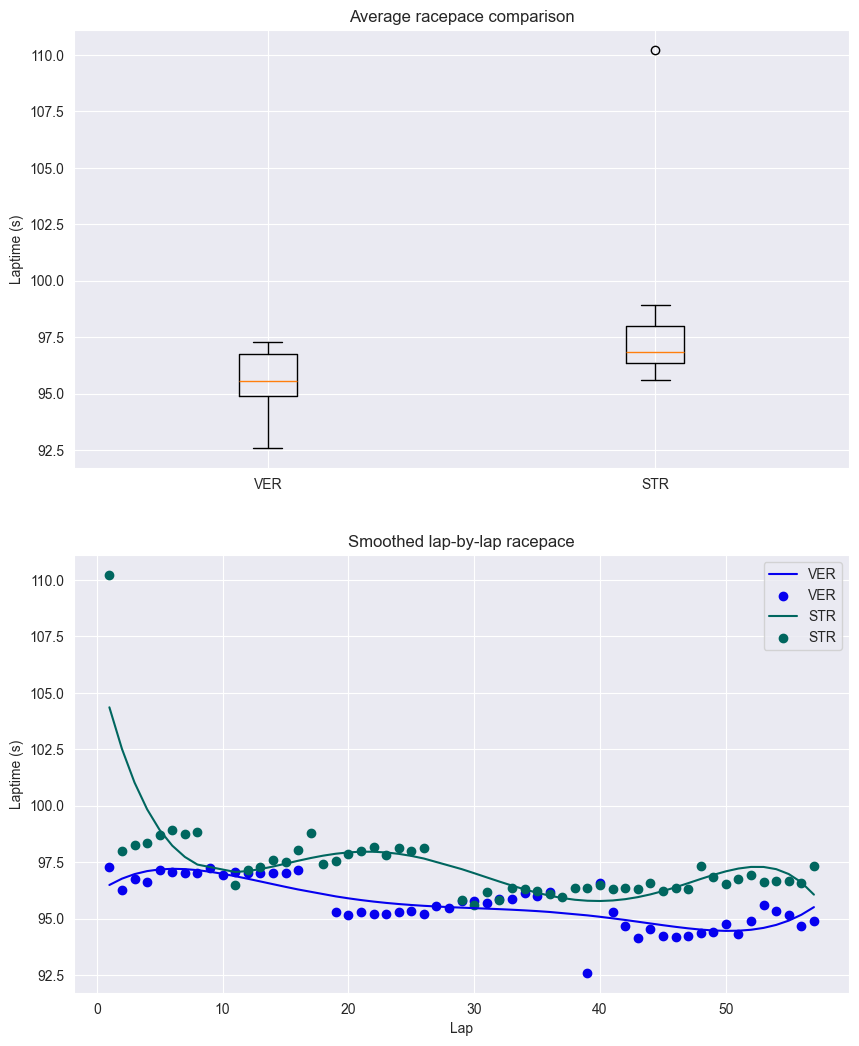

In [151]:
drivers_to_visualize = ['VER','STR']
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []
# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [10, 12.5]
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)


# Boxplot for average racepace
laptimes = [laps.pick_drivers(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize]

ax[0].boxplot(laptimes, tick_labels=drivers_to_visualize)

ax[0].set_title('Average racepace comparison')
ax[0].set(ylabel = 'Laptime (s)')

##############################
#
# Lap-by-lap racepace comparison
#
##############################
for driver in drivers_to_visualize:
    driver_laps = laps.pick_drivers(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    driver_laps = driver_laps.dropna()
    # Extract the team for coloring purposes
    team = pd.unique(driver_laps['Team'])[0]

    # X-coordinate is the lap number
    x = driver_laps['LapNumber']

    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])

    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'

    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.get_team_color(identifier = team, session = race), linestyle=linestyle)

    #Include scatterplot (individual laptimes)
    y = driver_laps['LapTimeSeconds']
    scatter_marker = 'o' if team not in visualized_teams else '^'
    ax[1].scatter(x, y, label=driver, color=ff1.plotting.get_team_color(identifier = team, session = race), marker=scatter_marker)

    # Append labels
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')

    # Set title
    ax[1].set_title('Smoothed lap-by-lap racepace')

    # Generate legend
    ax[1].legend()

    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

NameError: name 'driver_performance' is not defined

In [ ]:
weather = quali.weather_data.groupby('Rainfall')['Time'].count().reset_index()
dry = weather[weather['Rainfall'] == False]['Time'].values[0]
wet = weather[weather['Rainfall'] == True]['Time'].values[0]
condition = ""
if dry / (dry + wet) > 0.9:
    condition = "dry"
elif dry / (dry + wet) > 0.4:
    condition = "changeable"
else:
    condition = "wet"

condition